In [2]:
import pandas as pd
import numpy as np
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
# loading dataset
train = pd.read_csv('../input/plant-pathology-2021-fgvc8/train.csv')
train.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [4]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer().fit(train.labels.apply(lambda x : x.split()))
labels = pd.DataFrame(mlb.transform(train.labels.apply(lambda x : x.split())), columns = mlb.classes_)

labels = pd.concat([train['image'], labels], axis=1)
labels.head()

,image,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
0,800113bb65efe69e.jpg,0,0,1,0,0,0
1,8002cb321f8bfcdf.jpg,1,1,0,0,0,1
2,80070f7fb5e2ccaa.jpg,0,0,0,0,0,1
3,80077517781fb94f.jpg,0,0,0,0,0,1
4,800cbf0ff87721f8.jpg,1,0,0,0,0,0


In [5]:
from keras.preprocessing.image import ImageDataGenerator
img_gen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2
)

In [7]:
batch_size = 16
IMG_W, IMG_H = 380, 380
target_size = (IMG_W, IMG_H)
# image_path = '/kaggle/input/plant-pathology-2021-fgvc8/train_images'
image_path = '/kaggle/input/resized-plant2021/img_sz_384'

img_iter = img_gen.flow_from_dataframe(
    labels,
    directory=image_path,
    shuffle=True,
    class_mode="raw",
    color_mode="rgb",
    x_col='image',
    y_col=labels.columns.tolist()[1:],
    target_size=target_size,
    batch_size=batch_size,
    subset='training'
)

img_iter_val = img_gen.flow_from_dataframe(
    labels,
    directory=image_path,
    shuffle=True,
    class_mode="raw",
    color_mode="rgb",
    x_col='image',
    y_col=labels.columns.tolist()[1:],
    target_size=target_size,
    batch_size=batch_size,
    subset='validation'
)

Found 14906 validated image filenames.
Found 3726 validated image filenames.


In [8]:
from tensorflow.keras.applications import EfficientNetB4
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras import Model

base_model = EfficientNetB4(
    include_top=False,
    weights='../input/keras-pretrained-models/EfficientNetB4_NoTop_ImageNet.h5',
    input_shape=(IMG_W, IMG_H, 3)
)

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=BatchNormalization()(x)
x=Dense(64,activation='relu')(x)
x=Dropout(0.3)(x)
x=Dense(32,activation='relu')(x)
x=Dropout(0.3)(x)

predictions = Dense(len(labels.columns.tolist()[1:]), activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

In [9]:
model_checkpoint = ModelCheckpoint(
    filepath="./pp2021.h5", 
    monitor='val_loss', 
    save_best_only=True, 
    verbose=1,
    mode='min')

early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0,
    patience=10, 
    verbose=1, 
    restore_best_weights=True)

history = model.fit(
    img_iter,
    validation_data=img_iter_val,
    epochs=20,
    callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/20
932/932 [==============================] - 779s 813ms/step - loss: 0.4114 - accuracy: 0.5450 - val_loss: 0.7491 - val_accuracy: 0.2136

Epoch 00001: val_loss improved from inf to 0.74906, saving model to ./pp2021.h5
Epoch 2/20
932/932 [==============================] - 739s 793ms/step - loss: 0.2216 - accuracy: 0.7739 - val_loss: 1.8891 - val_accuracy: 0.1723

Epoch 00002: val_loss did not improve from 0.74906
Epoch 3/20
932/932 [==============================] - 737s 791ms/step - loss: 0.1763 - accuracy: 0.8274 - val_loss: 2.7909 - val_accuracy: 0.1538

Epoch 00003: val_loss did not improve from 0.74906
Epoch 4/20
932/932 [==============================] - 742s 796ms/step - loss: 0.1689 - accuracy: 0.8277 - val_loss: 1.5380 - val_accuracy: 0.1116

Epoch 00004: val_loss did not improve from 0.74906
Epoch 5/20
932/932 [==============================] - 737s 791ms/step - loss: 0.1542 - accuracy: 0.8391 - val_loss: 16.2026 - val_accuracy: 0.1076

Epoch 00005: val_loss did not i

In [10]:
import keras
def load_best_model():
    m = keras.models.load_model(
        "./pp2021.h5"
    )
    return m

In [11]:
model = load_best_model()

In [12]:
import matplotlib.pyplot as plt

def plotHistory(result):
    plt.plot(result.history['accuracy'])
    plt.plot(result.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

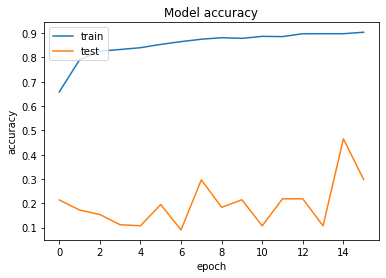

In [13]:
plotHistory(history)

In [14]:
base_model.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

epochs = 10
history = model.fit(
    img_iter,
    validation_data=img_iter_val,
    epochs=epochs,
    callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/10
932/932 [==============================] - 758s 795ms/step - loss: 0.1194 - accuracy: 0.8661 - val_loss: 0.1071 - val_accuracy: 0.8862

Epoch 00001: val_loss improved from 0.62773 to 0.10713, saving model to ./pp2021.h5
Epoch 2/10
932/932 [==============================] - 738s 792ms/step - loss: 0.1149 - accuracy: 0.8756 - val_loss: 0.0967 - val_accuracy: 0.8870

Epoch 00002: val_loss improved from 0.10713 to 0.09673, saving model to ./pp2021.h5
Epoch 3/10
932/932 [==============================] - 740s 794ms/step - loss: 0.1068 - accuracy: 0.8903 - val_loss: 0.0989 - val_accuracy: 0.8967

Epoch 00003: val_loss did not improve from 0.09673
Epoch 4/10
932/932 [==============================] - 741s 795ms/step - loss: 0.1086 - accuracy: 0.8873 - val_loss: 0.0907 - val_accuracy: 0.9042

Epoch 00004: val_loss improved from 0.09673 to 0.09074, saving model to ./pp2021.h5
Epoch 5/10
932/932 [==============================] - 738s 792ms/step - loss: 0.1048 - accuracy: 0.8899 - val

In [ ]:
plotHistory(history)

In [ ]:
model = load_best_model()

In [ ]:
test_df = pd.read_csv('../input/plant-pathology-2021-fgvc8/sample_submission.csv')
test_path = "../input/plant-pathology-2021-fgvc8/test_images"

In [ ]:
image_test_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [ ]:
test_generator = image_test_datagen.flow_from_dataframe(
    test_df,
    directory = test_path,
    x_col = "image",
    y_col = "labels",
    target_size = target_size,
    color_mode="rgb",
    batch_size=1,
    shuffle=False,
    seed=42,
    subset=None
)

In [ ]:
predicts = model.predict(test_generator)

In [ ]:
verdict = (predicts>0.50)
label = labels.columns.tolist()[1:]
answer = []
for i in range(verdict.shape[0]):
    tmp = []
    for j, c in enumerate(label):
        if verdict[i, j]:
            tmp.append(c)
    answer.append(tmp)
    
answer = [' '.join(t) for t in answer]

In [ ]:
test_df['labels'] = np.array(answer)
test_df

In [ ]:
test_df.to_csv('submission.csv', index=False)